<a href="https://colab.research.google.com/github/ikonushok/AI-Traiding/blob/main/%D0%9F%D1%80%D0%B8%D0%BC%D0%B5%D1%80_%D0%BF%D1%80%D0%B8%D0%BC%D0%B5%D0%BD%D0%B5%D0%BD%D0%B8%D1%8F_RL_%D1%81_%D0%BD%D1%83%D0%BB%D1%8F__%D0%B2_%D1%84%D0%B8%D0%BD%D1%82%D0%B5%D1%85%D0%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import random
import torch
from matplotlib import pyplot as plt
from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")

In [3]:
import torch.nn as nn
import torch.nn.functional as F

In [4]:
import plotly
import plotly.graph_objs as go

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [6]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [7]:
# torch.cuda.get_device_name(0)

# Мотивация

Когда мы сталкиваемся с числовыми рядами, то сразу возникает вопрос об их стационарности (об этом поговорим в отдельной статье). Когда числовой ряд стационарен (у него постоянные средняя, дисперсия и отсутствует тренд), но задача легко решается классическими методами машинного обучения (ML).

Если же числовой ряд нестационарен, например, курс акций, то при его прогнозировании или классификации вознкают сложности. Такие исследования требуют затрат и для успеха требуется определенный подход к обучению нейронных сетей.

И тут намм на помощь приходит `Reinforcement Learning`, который особенно полезен, когда проблема может быть установлена ​​как MDP, и предвещает хорошие результаты, когда `Среда` или `Вознаграждение` нестационарны, т. е. значительно меняются со временем.



# Немного теории о Reinforcement Learning

Как вы, возможно, уже знаете, основными двумя частями системы обучения с подкреплением являются:

**Среда (Environment)** — это «игровое поле» или в нашем случае рынок, который может подсказать нам, что происходит прямо сейчас и какова будет наша награда в будущем, если мы совершим какое-то действие прямо сейчас. То, с чем взаимодействует `Агент`.

**Агент (Agent)** — «игрок», который взаимодействует с окружающей средой и учится максимизировать долгосрочное вознаграждение, выполняя различные действия в различных ситуациях. Выбирает действия, основываясь на том, что известно о `Среде` из собранных данных и политики.

**Действие (Action)** - Различные варианты действий, которые `Агент` может выбрать в каждый момент времени.

**Состояние (State)** - Текущая ситуация агента.

**Награда или Вознаграждение (Reward)** -  обратная связь от `Среды`, которая нужна агенту, чтобы узнать, было ли предпринятое `Действие` хорошим.

**Политика (Policy)** - Процесс выбора действий на основе известной информации об окружающей среде.

**Ценность (Value)** - будущая награда, которую агент получит, совершив действие в определенном состоянии.

Графически это можно представить на следующей схеме:


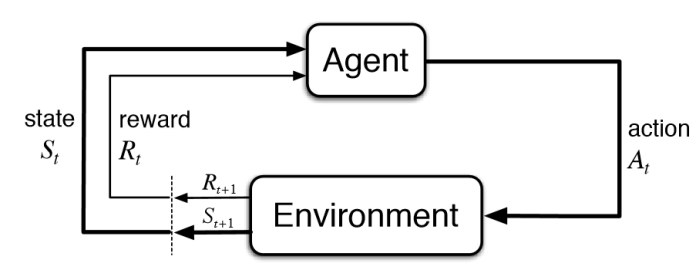
<center>Иллюстрация с https://www.kdnuggets.com/2018/03/5-things-reinforcement-learning.html<center>


Упомянем также о  **Марковских процессах принятия решений (Markov Decision Proces (MDP))** - это последовательность временных шагов, в которых происходит взаимодействие с окружающей средой.

В каждый момент времени текущее состояние используется для выполнения шага действия, после чего среда предоставляет обратную связь в виде вознаграждения об этом шаге и новом состоянии.

# Рабочая среда

Если состояния сложны и их трудно представить в виде таблицы действий, их можно аппроксимировать с помощью нейронной сети (это то, что мы будем делать).

С помощью нейронной сети мы можем выбрать самое прибыльное действие в каждом состоянии (согласно нашей функции `Q`) и максимизировать награду. 

Но как построить такую функцию `Q`? Здесь нам поможет алгоритм `Q-Learning`, основой которого будет знаменитое `уравнение Беллмана`:




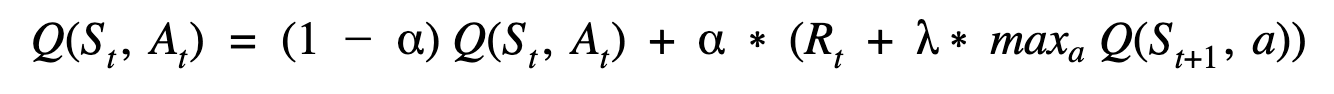

<center>Иллюстрация с https://towardsdatascience.com/deep-q-learning-tutorial-mindqn-2a4c855abffc<center>

**S** = Состояние или наблюдение

**A** = Действие, которое предпринимает агент

**R** = Награда за действие

**t** = Временной шаг

**Ɑ** = Скорость обучения

**ƛ** = Коэффициент дисконтирования, из-за которого вознаграждения со временем теряют свою ценность, поэтому более немедленные вознаграждения ценятся выше.

И немного про **Дисконтирование**:

В RL агент стремится к оптимальной политике, набору шагов, которые приводят к траектории (стратегии), обеспечивающей наибольшую награду.

Это достигается путем оценки прямого вознаграждения за каждый следующий шаг плюс оценка вознаграждения за все будущие шаги при совершении этого действия.

Когда это непрерывная задача, расчет всех будущих вознаграждений невозможен, а оценка вознаграждения за большое количество шагов в будущем часто сопряжена с неопределенностью.

Таким образом, `Дисконтирование` гарантирует, что больший вес придается ожидаемым вознаграждениям в ближайшем будущем, а меньший — более неопределенным вознаграждениям в отдаленном будущем.

# Подходы к реализации Reinforcement Learning

Часто можно слышать споры о том, что тот или иной алгоритм RL лучше другого. При каждая из `авторитетных сторон` забывает, что выбор алгоритма зависит от того, насколько можно `просчитать` саму среду или ее изменение, а также, зависит ли само изменение среды от действий агента.

**Одной из наиболее важных точек ветвления в алгоритме RL является вопрос о том, имеет ли агент доступ к модели среды (или изучает ее).**

Под моделью среды мы подразумеваем функцию, которая предсказывает переходы состояний и вознаграждения.

Алгоритмы, использующие модель, называются методами, основанными на модели `model-based`, а те, которые не используют модель, называются безмодельными `model-free`.

В то время как безмодельные методы отказываются от потенциального повышения эффективности выборки за счет использования модели, их, как правило, легче реализовать и настроить.



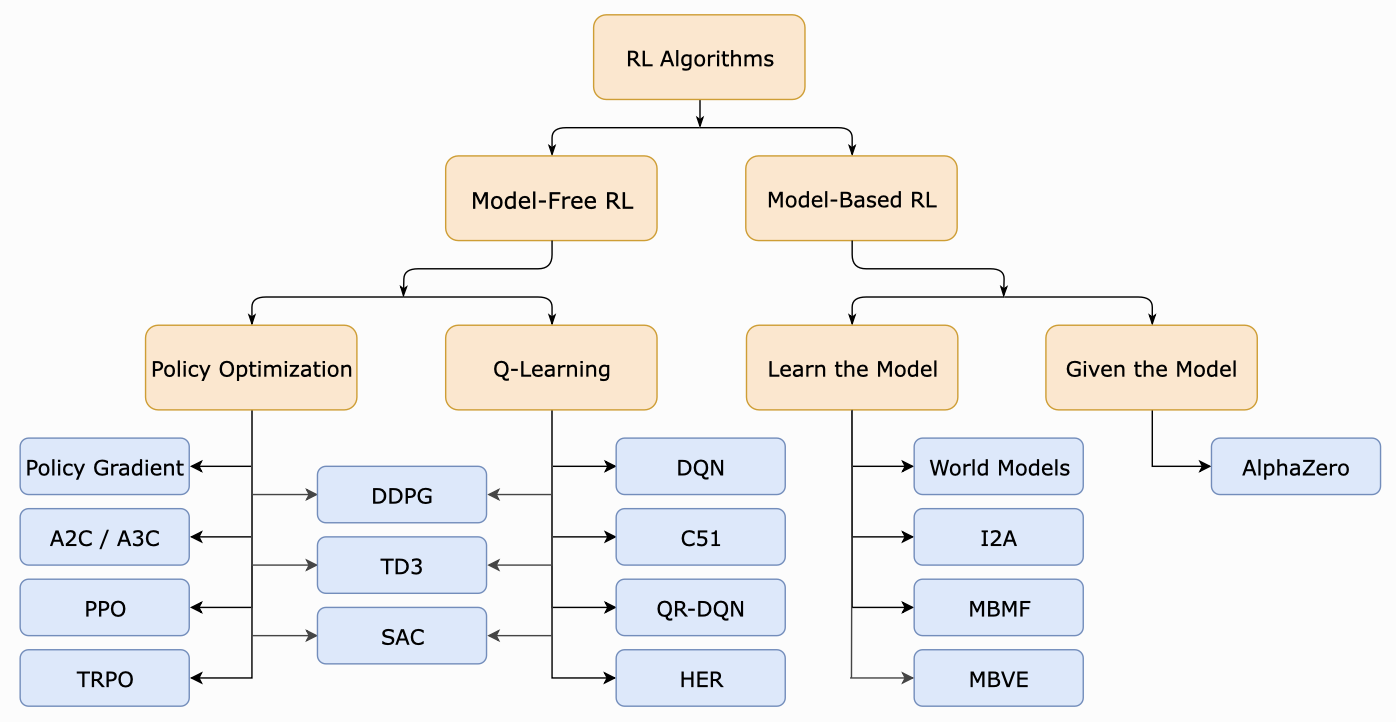

<center>Иллюстрация с https://spinningup.openai.com/en/latest/spinningup/rl_intro2.html#citations-below<center>

Со своей стороны очень рекомендую, прежде чем принимать решение о том, какой метод Вы будете использовать, подумать о том, а годен ли он для Вашей задачи.

# Процесс обучения нашей нейронной сети с помощью Deep Q-Learning:


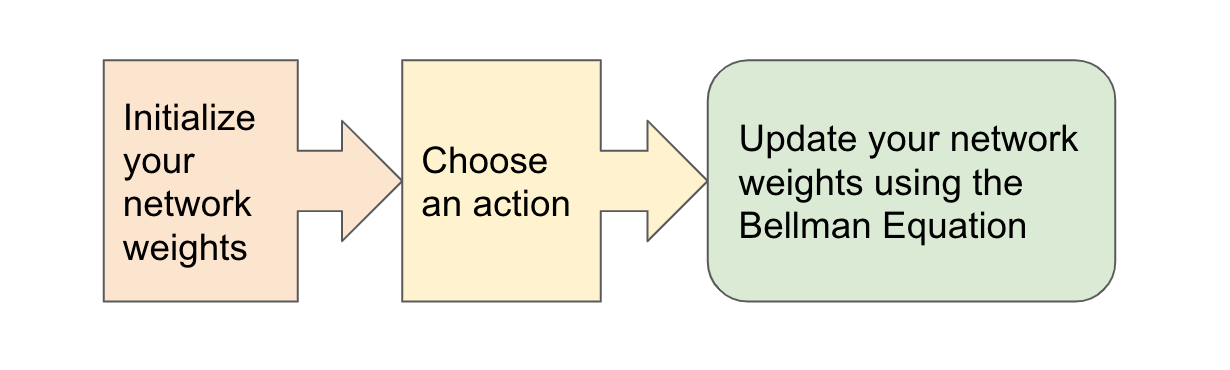

<center>Иллюстрация с https://towardsdatascience.com/deep-q-learning-tutorial-mindqn-2a4c855abffc<center>

1. Инициализируем нейронную сеть

2. Выберем действие.

3. Обновим веса сети, используя уравнение Беллмана.

Другими словами, мы будем итеративно, на каждом шаге `t`, обновлять значение, соответствующее состоянию `S` и заданному действию `A`, с двумя весовыми частями:
 - Текущее значение функции Q для этого состояния и действия
 - Награда за такое решение + долгосрочная награда от будущих шагов
 
`Альфа` здесь измеряет компромисс между текущим значением и новым вознаграждением (т. е. скоростью обучения), `гамма` дает вес для долгосрочного вознаграждения. 

Кроме того, во время итераций (обучения) в нашей среде мы иногда будем действовать случайным образом с некоторой вероятностью `эпсилон` — чтобы позволить нашему агенту изучить новые действия и потенциально еще большие награды! 

Обновление функции `Q` в случае аппроксимации нейронной сети будет означать аппроксимацию нашей нейронной сети `Q` новым значением для данного действия.


In [8]:
class Environment:
    '''
        Рабочая среда робота, внутри которого будет 
        происходить дальнейшее обучение 
    '''
    def __init__(self, length = 100, normalize = True, noise = True, data = []):
        self.length = length

        if len(data) == 0:
            # Если данные не поданы, формируем их сами 
            # на основе синуса размером length
            self.data = pd.DataFrame(np.sin(np.arange(length) / 30.0))
        else:
            # Иначе подугружаем существующие
            self.data = data
        

        if noise:
            # Подаем шум для данных от 0.1 до 1
            self.data += pd.DataFrame(np.random.normal(0, 0.1, size=(length, )))

        if normalize:
            # Нормализация после данных после шума
            self.data = (self.data - self.data.min()) / (self.data.max() - self.data.min())

    def get_state(self, time, lookback, diff = True):
        """
        Возвращаем производные отдельного окна в нашей выборке
        и убираем нули в начале
        """
        window = self.data.iloc[time-lookback:time]
        if diff: window = window.diff().fillna(0.0)
        return window

    def get_reward(self, action, action_time, reward_time, coef = 100):
        """
        Основная логика получения награды
        0 => long 1 => hold 2 => short
        """
        if action == 0:
            action = 1
        elif action == 1:
            action = 0
        else:
            action = -1
        # print(23, self.data)
        # Вытаскиваем текущую цену
        price_now = self.data.iloc[action_time]
        # Вытаскиваем следующую цену
        price_reward = self.data.iloc[reward_time]
        # Получаем разницу в проценте
        price_diff = (price_reward - price_now) / price_now
        # Прибавляем к портфелю следующее число:
        # Дельта изменения валюты * покупку/продажу/холд * коэф. закупки
        reward = np.sign(price_diff) * action * coef
        # print(12121, reward)
        return reward.values.tolist()[0]

## Пример создания среды для обучения `Агента`

С помощью нашего кода мы можем создавать Среду разной протяженности и, при необходимости, зашумлять ее, приближая к реальным условиям:

In [9]:
# Создадим тестовую среду
lin_env = Environment(normalize=True, noise=True)
# Отобразим все производные отдельного окна с 95 по 100 выборку
lin_env.get_state(100, 5, True)

,0
95,0.000000
96,0.110855
97,-0.028552
98,-0.045637
99,-0.044267


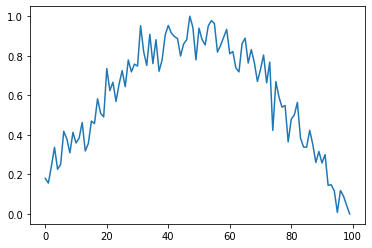

In [10]:
# Отобразим сгенерированные данные внутри среды
plt.figure()
plt.plot(lin_env.data)
plt.show()

In [11]:
print(f' Протяженность Среды: {-lin_env.get_reward(0, 50, 51)}')

 Протяженность Среды: 100.0


### Примечания по реализации нашего кода

Реализация классов `Environment` и `Agent` относительно проста, но я хотел бы еще раз обрисовать цикл обучения здесь:

Итерация происходит в течение `N` эпох, где каждая эпоха — это общая среда итерации.

Для каждого образца в среде мы:
1. Получаем `текущее состояние` в момент времени `t`
2. Получим `функцию значений` для всех действий в этом состоянии (наша нейросеть выдаст нам 3 значения)
3. Выполним `действие` в этом состоянии (например, действуйем случайным образом, исследуя)
4. Получим `награду` за это действие от окружения (см. класс)
5. Получим `следующее состояние` после текущего (для будущих долгосрочных вознаграждений)
6. `Сохраним кортеж` текущего состояния, следующего состояния, функции значения и вознаграждения за повтор опыта.
7. `Воспроизведем опыт` — подгоним нашу нейронную сеть к некоторым образцам из буфера воспроизведения опыта, чтобы сделать функцию `Q` более адекватной в отношении того, какие награды мы получаем за действия на этом этапе.

Рекомендую прочитать подробнее [здесь](https://deeplizard.com/learn/video/Bcuj2fTH4_4) , но в двух словах лучше тренироваться на некоррелированных мини-пакетах данных, чем на очень коррелированных пошаговых наблюдениях — это помогает обобщению и сходимости.

## Агент

Архитектура нашей нейронной сети очень будет очень похожа на простую нейронную сеть классификации с несколькими классами (см. Рисунок 4)

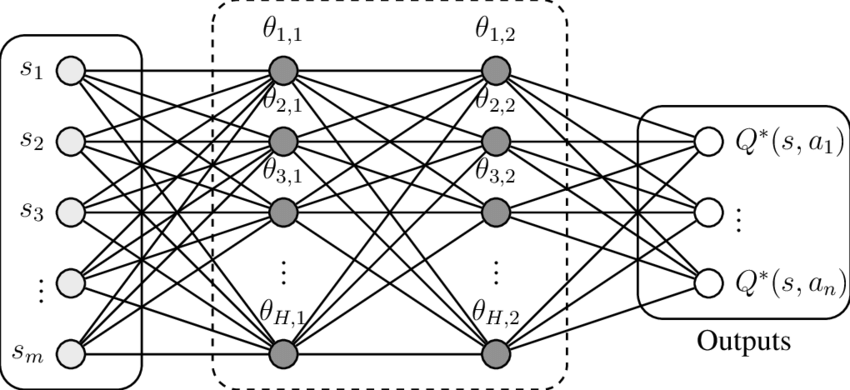

<center>Иллюстрация с https://medium.com/@vincentpeijnenburg/a-reinforcement-learning-approach-to-dynamic-pricing-in-an-airline-simulation-competition-8db537f2382f<center>

Функции, которые представляют состояние, находятся слева, затем есть скрытые слои с функциями активации, такими как relu, которые допускают нелинейные отношения и сложные взаимодействия, а справа находится выходной слой.

Однако вместо использования функции softmax для преобразования выходных данных в распределение вероятностей выходные данные останутся абсолютными значениями.

Образно говоря, это на самом деле это больше похоже на настройку регрессии с несколькими выходами.

In [17]:
import collections

In [18]:
# Обратите внимание на то, что в RL часто используются совсем простые нейронные сети
class Net(nn.Module):
    """Строим простую модель нейронки"""
    def __init__(self, state_shape, action_shape):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(state_shape, 10)
        self.fc2 = nn.Linear(10, action_shape)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [19]:
# Создадим экземпляр модели с 10 входами, 3 выходами
# и отобразим ее
net = Net(10, 3)
net

Net(
  (fc1): Linear(in_features=10, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=3, bias=True)
)

In [20]:
class BuyHoldSellAgent:
    '''
        Агент для покупки продажи
    '''
    def __init__(self, state_shape = 10, action_shape = 3, experience_size = 100):
        self.state_shape = state_shape
        self.action_shape = action_shape
        self.experience_size = experience_size
        self.experience = collections.deque(maxlen=self.experience_size)

        # Создадим экземпляр модели
        self.model = Net(state_shape, action_shape)

        # Создадим функцию ошибки
        self.criterion = nn.MSELoss()
        # Добавим оптимизатор
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.1)

    def save_experience(self, state_i, q_value_i, action_i, reward_i, state_i_1):
        """Метод для сохранения предудыщих данных эксперимента"""
        self.experience.append({
            'state_i': state_i,
            'q_value_i': q_value_i,
            'action_i': action_i,
            'reward_i': reward_i,
            'state_i_1': state_i_1
        })

    def replay_experience(self, alpha, gamma, sample_size):
        """Метод для оптимизации данных тренировки"""
        # Создаем фиксированную выборку из добавленных событий
        indices_sampled = np.random.choice(
            len(self.experience), 
            sample_size, 
            replace=False
        )
        # Проходимся только по тем элементам, которые были добавлены в выборку
        for i, e in enumerate(self.experience):
            if i in indices_sampled:
                state_i, action_i, reward_i, q_value_i = e['state_i'], e['action_i'], e['reward_i'], e['q_value_i']
                state_i_1 = e['state_i_1']

                # Получаем прогноз по следующему состоянию
                q_value_i_1 = self.get_value_action_value(state_i_1.values.reshape(1, WINDOW_SHAPE))[None, ...]

                # Отсоединяем тензор и кидаем в новую переменную 
                y_i = q_value_i.detach()
                
                # Уравнение Бэллмена
                # Суть в том, что мы берем максимально возможную награду 
                # из действия из будущего шага (q_value_i_1) , умножаем ее на гамму 
                # (коэф. значимости будущих наград), прибавляем к текущей награде
                # и заносим в Q таблицу для обучения
                y_i[action_i] = (1 - alpha) * y_i[action_i] + alpha * (reward_i + gamma * max(q_value_i_1.detach().numpy()[0]))
                
                outputs = self.model(torch.from_numpy(np.expand_dims(state_i.values.reshape(1, WINDOW_SHAPE), 0)).float())[0]
                loss = self.criterion(outputs, torch.Tensor(y_i))
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

    def get_value_action_value(self, state):
        """Метод для прогноза сигнала"""
        pred = self.model(torch.from_numpy(np.expand_dims(state, 0)).float())
        return pred.flatten()

In [ ]:
# Создадим нового агента
agent = BuyHoldSellAgent()

In [22]:
# Попробуем предсказать на линейной выборке
agent.get_value_action_value(
    pd.DataFrame(np.array([range(10)]))
)

tensor([-0.9167, -1.2517, -1.1674], grad_fn=<ReshapeAliasBackward0>)

# Тренировка сети

В нашем случае, мы напренируем нашего Агента определять восходящие и нисходящие тренды на синусоиде и потом посмотрим, достаточно ли такой тренировки для решения более сложных задач (зашумленный сигнал и нестационарный временной ряд).

In [23]:
# Количество эпох обучения
epochs = 10
# Коэф. значимости награды на шаг вперед
gamma = 0.9
# Количество эпох обучения
epsilon = 0.95
# Скорость обучения
alpha = 0.9

In [24]:
# Размер датасета
DATASET_LENGTH = 250
# Размер окна из которого будут браться предыдущие данные
WINDOW_SHAPE = 5
# Шаг предыдущих данных
REWARD_TIME = 1
# Число доступных действий
ACTIONS_SHAPE = 3
# Размер выборки
SAMPLE_SIZE = 30

In [25]:
# Объявляем новую среду с агентом, данные будут генерироваться автоматически
environment = Environment(DATASET_LENGTH, True, False)
agent = BuyHoldSellAgent(WINDOW_SHAPE, ACTIONS_SHAPE)

In [26]:
environment.data

,0
0,0.499983
1,0.516647
2,0.533293
3,0.549902
4,0.566455
...,...
245,0.975759
246,0.970368
247,0.964455
248,0.958026


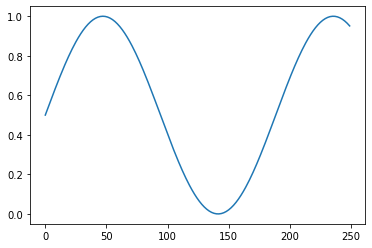

In [27]:
# Отобразим сгенерированные данные внутри среды
plt.figure()
plt.plot(environment.data)
plt.show()

In [28]:
for i in range(epochs):

    learning_progress = []
    for j in range(WINDOW_SHAPE, DATASET_LENGTH - REWARD_TIME, REWARD_TIME): 
        print(f"{i} / {epochs} : {j} {DATASET_LENGTH - REWARD_TIME}", end='\r')

        # 1. Получаем текущее состояние. Производные в отдельном интервале
        # Текущий Y на графике и предыдущие WINDOW_SHAPE шагов
        state_j = environment.get_state(j, WINDOW_SHAPE)
        # Получаем предсказание по данному состоянию через модель
        q_value_j = agent.get_value_action_value(state_j.values.reshape(1, WINDOW_SHAPE))

        # 2. Выбираем действие для текущего состояния
        # В зависимости от длины эпсилона, выбираем случайное действие 
        # или реальные по предсказаниям
        if (np.random.random() < epsilon):
            action = np.random.randint(0, ACTIONS_SHAPE)
        else:
            action = (np.argmax(q_value_j.detach()))

        # 3. Получаем награду за выбранное действие
        reward_value_j = environment.get_reward(action, j, j + REWARD_TIME)
        learning_progress.append(reward_value_j)

        # 4. Получаем будущее состояние. Производные в будущем интервале
        # Текущий Y + 1 на графике и предыдущие WINDOW_SHAPE шагов
        state_j_1 = environment.get_state(j + 1, WINDOW_SHAPE)

        # 5. Сохраняем все полученные данные в агента
        agent.save_experience(state_j, q_value_j, action, reward_value_j, state_j_1)
        
        # 6. Как только число ранее полученных сэмплов перевалило 
        # за необходимое, начинаем тренировать сеть
        if j > SAMPLE_SIZE * 2:
            agent.replay_experience(alpha, gamma, SAMPLE_SIZE)

    # С каждым шагом уменьшаем эпсилон, чтобы бот начинал действовать 
    # по собственным прогнозам и переставал изучать среду
    if epsilon > 0.1:
        epsilon -= 1.0 / epochs

    print('Epoch', i, '...', np.mean(learning_progress))
    learning_progress = []

Epoch 0 ... -0.4098360655737705
Epoch 1 ... 8.60655737704918
Epoch 2 ... 20.901639344262296
Epoch 3 ... 38.52459016393443
Epoch 4 ... 34.83606557377049
Epoch 5 ... 49.18032786885246
Epoch 6 ... 59.83606557377049
Epoch 7 ... 61.0655737704918
Epoch 8 ... 78.68852459016394
Epoch 9 ... 79.50819672131148


# Проверка

Давайте посмотрим, сможем ли мы получить какую-то прибыль, после обучения сети всего-лишь на 10 эпохах:

In [29]:
action_to_backtest_action = {
    0: 1,  # покупаем
    1: 0,  # ничего не делаем
    2: -1  # продаем
}

## Простой синус

In [30]:
actions = []
for j in range(WINDOW_SHAPE, DATASET_LENGTH, REWARD_TIME): 
    # Получаем производные в отдельном интервале
    # Текущая цена и предыдущие WINDOW_SHAPE шагов
    state_j = environment.get_state(j, WINDOW_SHAPE)
    # Получаем предикт бота по данным
    q_value_j = agent.get_value_action_value(state_j.values.reshape(1,WINDOW_SHAPE))
    # Определяем сигнал и записываем в события
    actions.append(action_to_backtest_action[np.argmax(q_value_j.detach().numpy())])

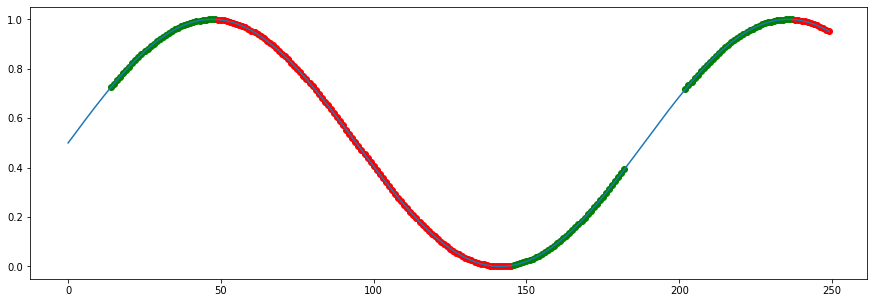

In [31]:
plt.figure(figsize = (15, 5))
plt.plot(environment.data)
for e, a in enumerate(actions):
    e += WINDOW_SHAPE
    if a == 1:
        plt.scatter(e, environment.data.iloc[e], color = 'green')
    elif a == -1:
        plt.scatter(e, environment.data.iloc[e], color = 'red')
    else:
        pass
plt.show()

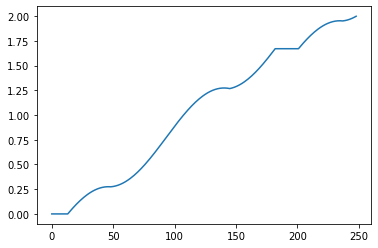

In [32]:
# Составляем график доходов. Сделаем фрейм формата Цена/Сигнал
backtest = pd.DataFrame({
    'price': environment.data.values.flatten(),
    # Первые 5 сигналов отсутствуют, мы должны расширить данные
    # и добавить дополнительные 5 элементов в начало с сигналом 0
    'signal': [0] * WINDOW_SHAPE + actions
})
# Получаем производные цен и делаем сдвиг
backtest['price_diff'] = backtest['price'].diff().shift(-1)
# Суммируем доходы и выводим график
(backtest['price_diff'] * backtest['signal']).cumsum().plot()

Идеально!

## Синус с разными частотами

Давайте усложним жизнь нашему агенту — просуммируем 4 функции косинуса с разными частотными периодами и попробуем торговать по этим объединенным волнам. 

Результат по-прежнему отличный — наше представление рынка четко отражает тенденции, и даже если наша модель была обучена на данных другого типа, она все равно знает, что делать с другой волной.

In [33]:
data_new = pd.DataFrame(
    np.cos(np.arange(DATASET_LENGTH)/5.0) + 
    np.cos(np.arange(DATASET_LENGTH)/10) + 
    np.cos(np.arange(DATASET_LENGTH)/20) + 
    np.cos(np.arange(DATASET_LENGTH)/30)
    )
print(data_new)

            0
0    4.000000
1    3.973265
2    3.893910
3    3.764447
4    3.588959
..        ...
245  1.749758
246  1.971078
247  2.162457
248  2.316891
249  2.428503

[250 rows x 1 columns]


In [34]:
environment3 = Environment(DATASET_LENGTH, True, True, data_new)
actions = []
for j in range(WINDOW_SHAPE, DATASET_LENGTH, REWARD_TIME): 
    # Получаем производные в отдельном интервале
    # Текущая цена и предыдущие WINDOW_SHAPE шагов
    state_j = environment3.get_state(j, WINDOW_SHAPE)
    # Получаем предикт бота по данным
    q_value_j = agent.get_value_action_value(state_j.values.reshape(1, WINDOW_SHAPE))
    # Определяем сигнал и записываем в события
    actions.append(action_to_backtest_action[np.argmax(q_value_j.detach().numpy())])

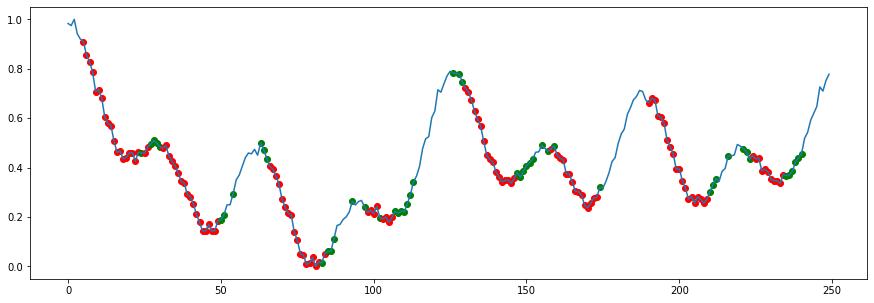

In [35]:
plt.figure(figsize = (15, 5))
plt.plot(environment3.data)
for e, a in enumerate(actions):
    e += WINDOW_SHAPE
    if a == 1:
        plt.scatter(e, environment3.data.iloc[e], color = 'green')
    elif a == -1:
        plt.scatter(e, environment3.data.iloc[e], color = 'red')
    else:
        pass
plt.show()

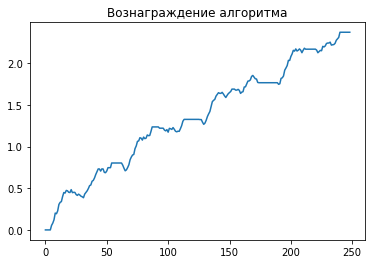

In [36]:
# Составляем график доходов. Сделаем фрейм формата Цена/Сигнал
backtest = pd.DataFrame({
    'price': environment3.data.values.flatten(),
    # Первые 5 сигналов отсутствуют, мы должны расширить данные
    # и добавить дополнительные 5 элементов в начало с сигналом 0
    'signal': [0] * WINDOW_SHAPE + actions
})
# Получаем производные цен и делаем сдвиг
backtest['price_diff'] = backtest['price'].diff().shift(-1)
# Суммируем доходы и выводим график
(backtest['price_diff'] * backtest['signal']).cumsum().plot()
plt.title('Вознаграждение алгоритма')
plt.show()

И опять, идеально :)

## Зашумленная синусоида

Теперь давайте немного усложним упражнение и `добавим гауссов шум` во временной ряд без переобучения модели.

Алгоритм работает хуже, но какую-то прибыль зарабатывает! Теперь есть некоторые запутанные моменты, но в среднем модель все еще узнает, где находятся долгосрочные тренды нашей зашумленной функции косинуса.

In [37]:
environment2 = Environment(DATASET_LENGTH, True, True)
actions = []
for j in range(WINDOW_SHAPE, DATASET_LENGTH, REWARD_TIME): 
    # Получаем производные в отдельном интервале
    # Текущая цена и предыдущие WINDOW_SHAPE шагов
    state_j = environment2.get_state(j, WINDOW_SHAPE)
    # Получаем предикт бота по данным
    q_value_j = agent.get_value_action_value(state_j.values.reshape(1, WINDOW_SHAPE))
    # Определяем сигнал и записываем в события
    actions.append(action_to_backtest_action[np.argmax(q_value_j.detach().numpy())])

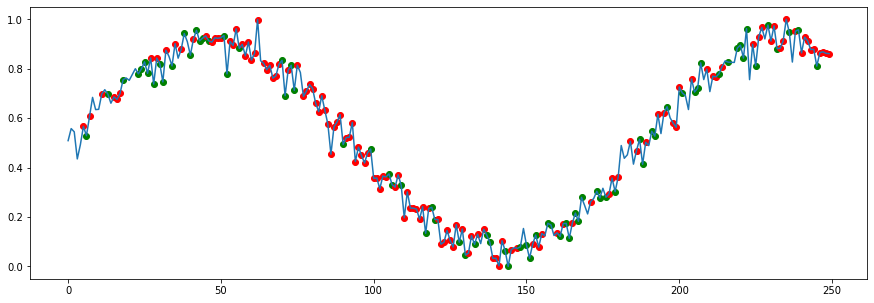

In [38]:
plt.figure(figsize = (15, 5))
plt.plot(environment2.data)
for e, a in enumerate(actions):
    e += WINDOW_SHAPE
    if a == 1:
        plt.scatter(e, environment2.data.iloc[e], color = 'green')
    elif a == -1:
        plt.scatter(e, environment2.data.iloc[e], color = 'red')
    else:
        pass
plt.show()

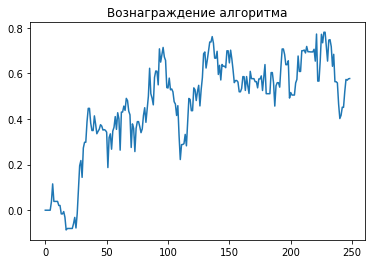

In [39]:
# Составляем график доходов. Сделаем фрейм формата Цена/Сигнал
backtest = pd.DataFrame({
    'price': environment2.data.values.flatten(),
    # Первые 5 сигналов отсутствуют, мы должны расширить данные
    # и добавить дополнительные 5 элементов в начало с сигналом 0
    'signal': [0] * WINDOW_SHAPE + actions
})
# Получаем производные цен и делаем сдвиг
backtest['price_diff'] = backtest['price'].diff().shift(-1)
# Суммируем доходы и выводим график
(backtest['price_diff'] * backtest['signal']).cumsum().plot()
plt.title('Вознаграждение алгоритма')
plt.show()

Не супер, но поверьте, подобрав гиперпараметры, и тут можно добиться такого-же прекрасного результата, как и в предыдущих примерах.

# Проверка алгоритма на реальных данных (акции Tesla)

Осталось проверить, сможем ли мы обогатиться, применив эту же нейронную сеть к реальным котировкам акций:

In [40]:
!pip install yfinance
clear_output()
import yfinance as yf

In [41]:
df = yf.download(tickers='TSLA')
df = df[-500:]
df = df.reset_index(drop=True)
print(df.head())

[*********************100%***********************]  1 of 1 completed
         Open        High         Low       Close   Adj Close     Volume
0  112.417999  115.036003  111.421997  114.599998  114.599998   68250000
1  118.031998  130.399994  116.106003  130.190002  130.190002  112377000
2  139.794006  148.376007  138.485992  141.977997  141.977997  152882500
3  148.399994  150.626007  142.000000  145.966003  145.966003  117885000
4  143.388000  151.889999  141.343994  149.042007  149.042007  103289500


In [42]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    y = df['Close'][:],
    line =  dict(shape =  'spline' ),
    name = 'Курс акции TSLA'
            ))
fig.show()

In [43]:
df['Close']

0       114.599998
1       130.190002
2       141.977997
3       145.966003
4       149.042007
          ...     
495    1091.839966
496    1099.569946
497    1093.989990
498    1077.599976
499    1084.589966
Name: Close, Length: 500, dtype: float64

In [44]:
# Прописываем новую среду и передаем данные о закрытии цены
environment4 = Environment(len(df['Close']), False, False, df['Close'])
actions = []

for j in range(WINDOW_SHAPE, len(df['Close']), REWARD_TIME): 
    # 1. Получаем производные в отдельном интервале
    # Текущая цена и предыдущие WINDOW_SHAPE шагов
    state_j = environment4.get_state(j, WINDOW_SHAPE)

    # Получаем предикт бота по данным
    q_value_j = agent.get_value_action_value(state_j.values.reshape(1, WINDOW_SHAPE))
    # Определяем сигнал и записываем в события
    actions.append(action_to_backtest_action[np.argmax(q_value_j.detach().numpy())])

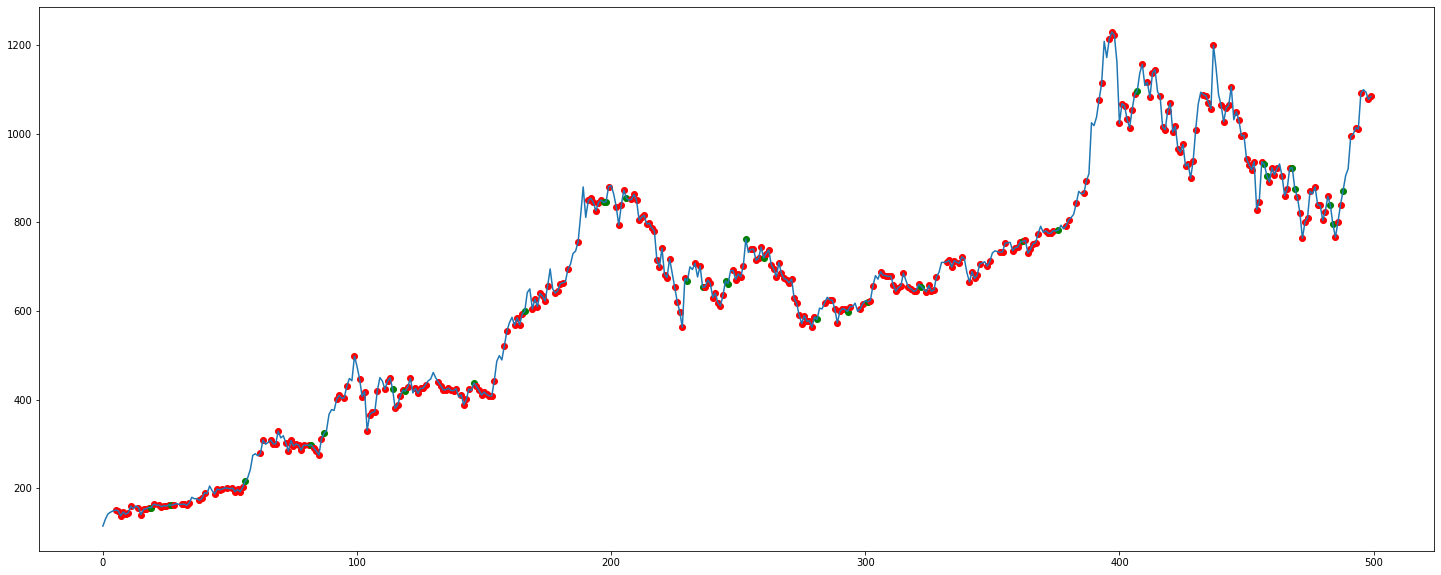

In [45]:
plt.figure(figsize = (25, 10))
plt.plot(environment4.data)
for e, a in enumerate(actions):
    print(f"{e} {a}", end='\r')
    e += WINDOW_SHAPE
    if a == 1:
        plt.scatter(e, environment4.data.iloc[e], color = 'green')
    elif a == -1:
        plt.scatter(e, environment4.data.iloc[e], color = 'red')
    else:
        pass
plt.show()

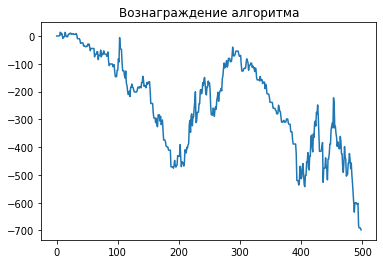

In [46]:
 # Составляем график доходов. Сделаем фрейм формата Цена/Сигнал
backtest = pd.DataFrame({
    'price': environment4.data.values.flatten(),
    # Первые 5 сигналов отсутствуют, мы должны расширить данные
    # и добавить дополнительные 5 элементов в начало с сигналом 0
    'signal': [0] * WINDOW_SHAPE + actions
})
# Получаем производные цен и делаем сдвиг
backtest['price_diff'] = backtest['price'].diff().shift(-1)
# Суммируем доходы и выводим график
(backtest['price_diff'] * backtest['signal']).cumsum().plot()
plt.title('Вознаграждение алгоритма')
plt.show()

## Почему вдруг мы не можем получить стабильный результат?

**Ответ:** в сильной нестационарности временного ряда и том, что наш Агент учился в Среде, сильно отличающейся от Среды, с которой ему пришлось столкнуться. 

В реальной жизни, котировки акции носят практически случайный характер: меняется среднее, дисперсия и частота изменений. Поэтому наша нейронная сеть `ловит` только частные случаи `несовершества рынка` и, в такие моменты, алгоритм увеличивает свое вознаграждение. А в остальное время - теряет..

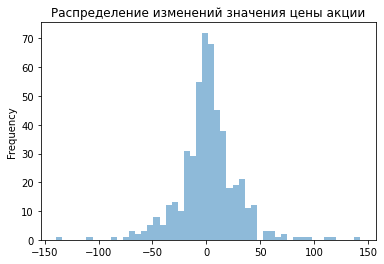

In [47]:
df['Close'].diff(1).plot.hist(bins=50, alpha=0.5)
plt.title('Распределение изменений значения цены акции')
plt.show()

## Почему я не рекомендую учиться на готовых `Симуляторах`:

Именно потому, что реальная жизнь очень разнообразна, а краткосрочные движения цены носят случайный характер, мало пользы в обучении RL на основе рафинированных (упрощенных) моделей, предлагаемых различными искусственными средами).

Нужно учиться самостоятельно описывать среду, агентаи вознаграждения. Только тогда Вы поймете, насколько это тонкая задача, требующая понимания взаимосвязи реальных факторов друг с другом и с действиями агента.

# Некоторые ссылки:

1. [Reinforcement Learning: An Introduction. Richard S. Sutton and Andrew G. Barto 2014, 2015](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf)
2. [Advances in Financial Machine Learning](https://www.amazon.com/Advances-Financial-Machine-Learning-Marcos/dp/1119482089)
3. [Trend following](https://en.wikipedia.org/wiki/Trend_following)
4. [Links to Algorithms in Taxonomy](https://spinningup.openai.com/en/latest/spinningup/rl_intro2.html#links-to-algorithms-in-taxonomy)